In [22]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Basmala Kamal\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [24]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("B:/tut-pricing-model/tints/tint_noon.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

#df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["name"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["name", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["name", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["name"].str.contains("Lip gloss|Lip Gloss|Lip Balm|Lip balm|Blackout|Eyebrow|Foundation|BB|Sunscreen|Window|Car", na=False)]
print(df)


                                                  name  price  page  \
400                     3ce Blur Water Tint Bake Beige  95.50     8   
47                          ANATASIA 3-Piece Tint Lips  11.10     1   
88                   Amuse Jel-Fit Tint 03 Nupink 3.8g  62.95     2   
93           Amuse Jel-Fit Tint 08 Gorgeous Mauve 3.8g  62.95     2   
432                            Amuse Jel-Fit Tint 3.8g  81.20     9   
..                                                 ...    ...   ...   
507  guam Unisex Red Rush Natural Lip And Cheek Tin...    164    10   
476      rom&nd Dewy·Ful Water Tint (13 Custard Mauve)    223    10   
479  rom&nd Glasting Water Tint Glossy Lipsticks 4 ...    193    10   
477     rom&nd Juicy Lasting Matte Tint (13Eat Dotori)    193    10   
73   the SAEM The Saem Saemmul Water Candy Tint 02 ...     69     2   

                                                   url  price_numeric  volume  
400  https://www.noon.com/saudi-en/search/?q=tint&p...          95.

In [25]:
import pandas as pd
from difflib import SequenceMatcher
def is_tint_related(name):
    name = str(name).lower()
    keywords = ['lip tint', 'cheek tint', 'tint', 'blush tint']
    for keyword in keywords:
        if keyword in name or SequenceMatcher(None, keyword, name).ratio() > 0.7:
            return True
    return False
df = df[df['name'].apply(is_tint_related)]
df.reset_index(drop=True, inplace=True)

In [26]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df["name"].apply(is_multi_item)

# Split the DataFrame
sets_df = df[mask_sets].copy()
df = df[~mask_sets].copy()

# Optional: Reset index if needed
sets_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [27]:
# Only compute if both volume and price are available
"""df["volume_per_price"] = df.apply(
    lambda row: row["volume"] / row["price_numeric"]
    if pd.notna(row["volume"]) and pd.notna(row["price_numeric"]) and row["price_numeric"] > 0
    else None,
    axis=1
)"""


'df["volume_per_price"] = df.apply(\n    lambda row: row["volume"] / row["price_numeric"]\n    if pd.notna(row["volume"]) and pd.notna(row["price_numeric"]) and row["price_numeric"] > 0\n    else None,\n    axis=1\n)'

In [28]:
print(df["price_numeric"].describe())


count      99.000000
mean      141.483333
std       224.653191
min        11.100000
25%        32.000000
50%        62.950000
75%       159.500000
max      1365.000000
Name: price_numeric, dtype: float64


In [29]:
#print(df["volume_per_price"].describe())


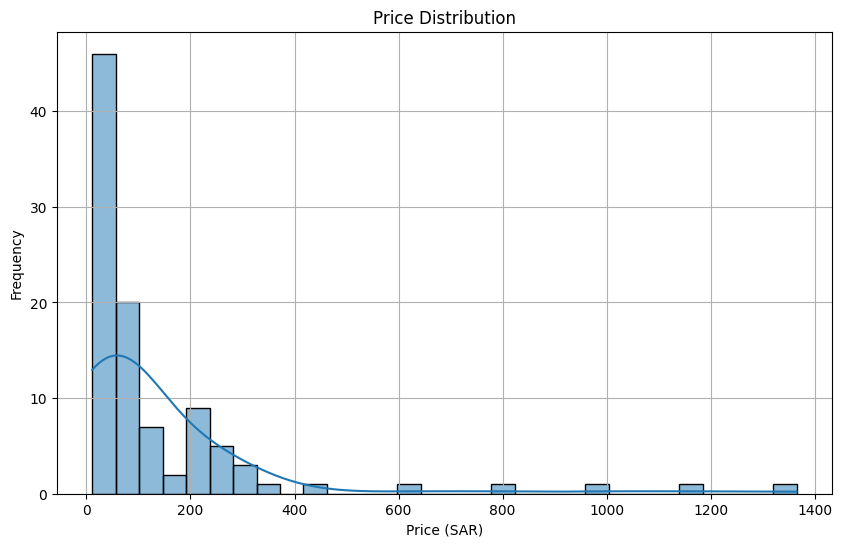

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [31]:
df_cleaned = df.dropna(subset=["name", "price_numeric"])
df_cleaned.shape

(99, 6)

In [32]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned["price_log"] = np.log1p(df_cleaned["price_numeric"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


In [33]:
df_cleaned.to_csv("B:/tut-pricing-model/tints/tint_noon_cleaned.csv", index=False)

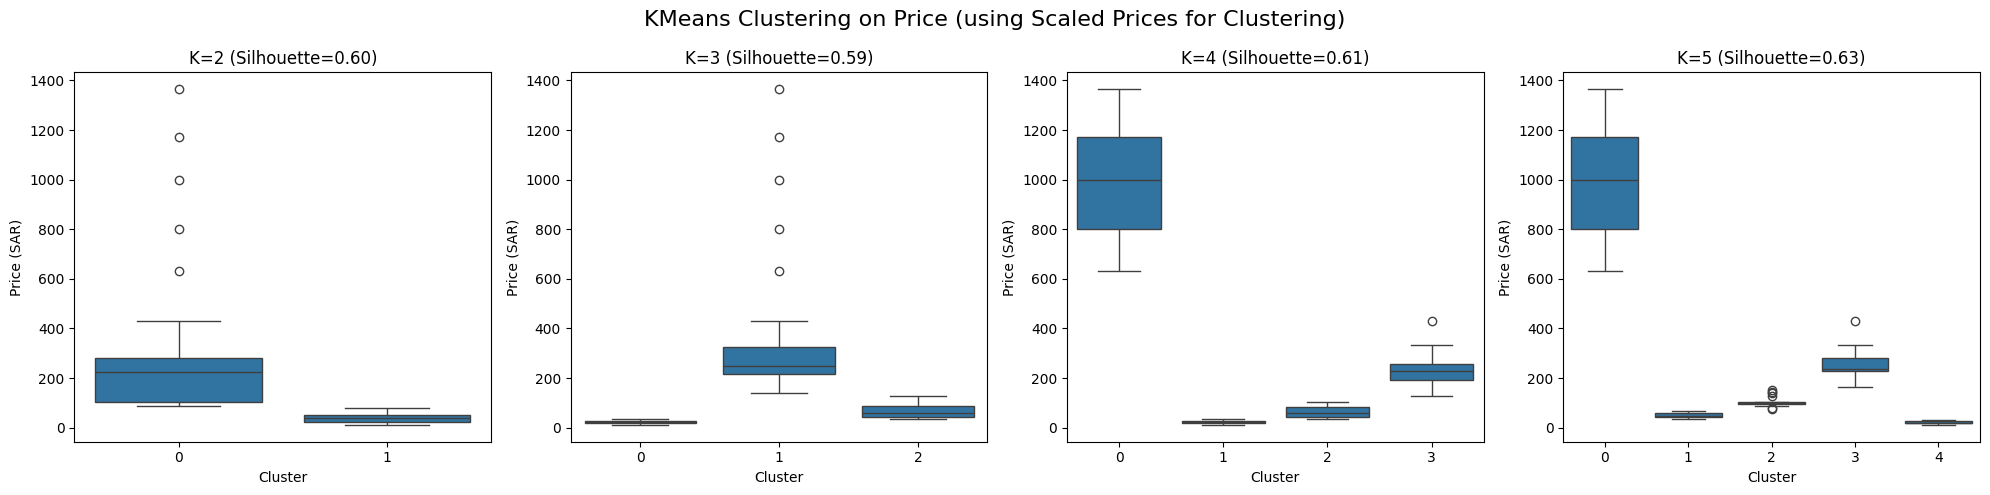

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


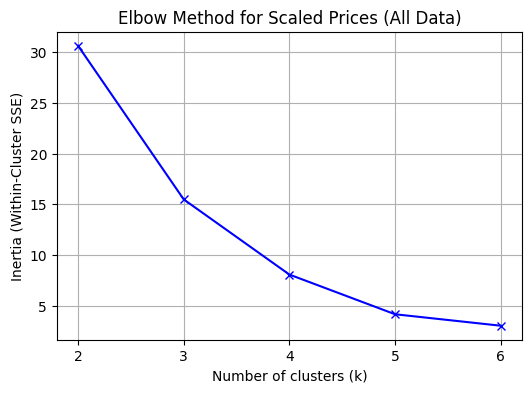

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Reassign cluster labels based on ascending mean price
df_cleaned = df_cleaned.copy()
df_cleaned["temp_cluster"] = kmeans.labels_

# Calculate mean price per cluster
cluster_means = (
    df_cleaned.groupby("temp_cluster")["price_numeric"]
    .mean()
    .sort_values()
    .reset_index()
)

# Create a mapping from original label to sorted label (e.g. {2: 0, 0: 1, 1: 2})
label_mapping = {row["temp_cluster"]: new_label for new_label, row in cluster_means.iterrows()}

# Apply new labels
df_cleaned["final_cluster"] = df_cleaned["temp_cluster"].map(label_mapping)
df_cleaned.drop(columns=["temp_cluster"], inplace=True)

# 4. Show actual price statistics per sorted cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["price_numeric"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean    min     max
final_cluster                                  
0                 26   21.463462   11.1    35.0
1                 45   65.877778   37.0   127.0
2                 28  374.439286  139.0  1365.0


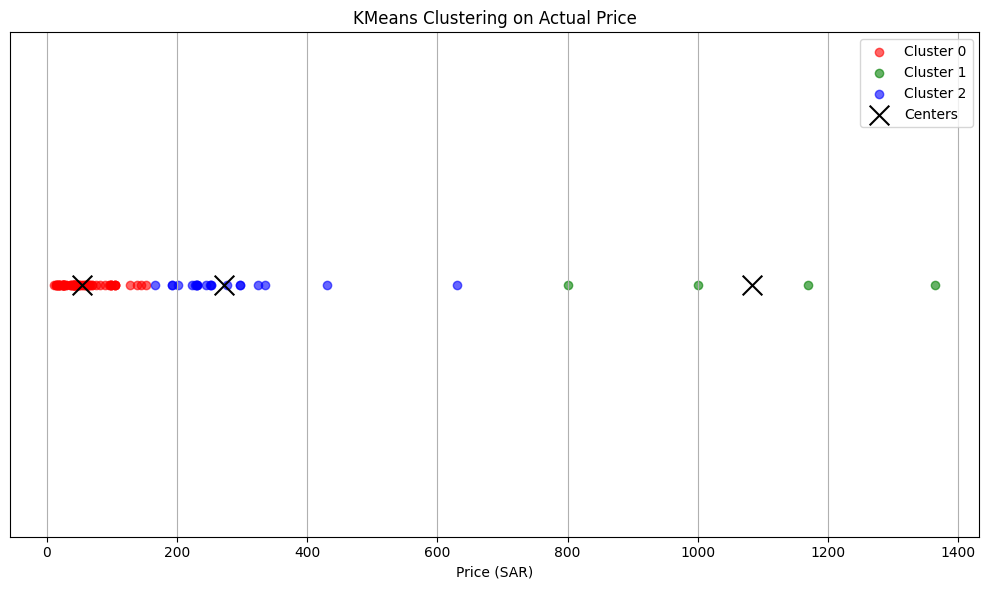

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Make sure 'price_numeric' exists in df_cleaned
df_cleaned = df_cleaned.copy()

# Prepare actual price data
X_price = df_cleaned[["price_numeric"]].values

# Run KMeans on actual prices
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)
df_cleaned["final_cluster"] = kmeans.labels_

# Plotting clusters based on actual price
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for cluster in range(k):
    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]
    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),
                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])

# Cluster centers (actual price values)
centers = kmeans.cluster_centers_.flatten()
plt.scatter(centers, [0] * k, c='black', s=200, marker='x', label='Centers')

# Plot config
plt.title("KMeans Clustering on Actual Price")
plt.xlabel("Price (SAR)")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == 0)
]
low

,name,price,page,url,price_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,3ce Blur Water Tint Bake Beige,95.50,8,https://www.noon.com/saudi-en/search/?q=tint&p...,95.50,NaN,4.569543,0.250063,0,2,2,2,0
1,ANATASIA 3-Piece Tint Lips,11.10,1,https://www.noon.com/saudi-en/search/?q=tint&p...,11.10,NaN,2.493205,-1.696342,1,0,1,4,0
2,Amuse Jel-Fit Tint 03 Nupink 3.8g,62.95,2,https://www.noon.com/saudi-en/search/?q=tint&p...,62.95,NaN,4.158102,-0.135631,1,2,2,1,0
3,Amuse Jel-Fit Tint 08 Gorgeous Mauve 3.8g,62.95,2,https://www.noon.com/saudi-en/search/?q=tint&p...,62.95,NaN,4.158102,-0.135631,1,2,2,1,0
4,Amuse Jel-Fit Tint 3.8g,81.20,9,https://www.noon.com/saudi-en/search/?q=tint&p...,81.20,NaN,4.409155,0.099712,1,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Voloria I'm Tattoo Velvet Tint 5grams,13.70,1,https://www.noon.com/saudi-en/search/?q=tint&p...,13.70,NaN,2.687847,-1.513880,1,0,1,4,0
92,Voloria I'm Tattoo Velvet Tint 5grams,17,1,https://www.noon.com/saudi-en/search/?q=tint&p...,17.00,NaN,2.890372,-1.324030,1,0,1,4,0
93,Voloria I'm Tattoo Velvet Tint 5grams,18.45,2,https://www.noon.com/saudi-en/search/?q=tint&p...,18.45,NaN,2.967847,-1.251402,1,0,1,4,0
94,YADAH Be My Tint Long Lasting Color Lip Tint Set,66,1,https://www.noon.com/saudi-en/search/?q=tint&p...,66.00,NaN,4.204693,-0.091956,1,2,2,1,0


In [39]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
mid

,name,price,page,url,price_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
48,NWK 100 Pieces Tint 3 Colors,"1,000",5,https://www.noon.com/saudi-en/search/?q=tint&p...,1000.0,NaN,6.908755,2.442892,0,1,0,0,1
49,NWK 120 Pieces Tint 3 Colors,"1,170",6,https://www.noon.com/saudi-en/search/?q=tint&p...,1170.0,NaN,7.065613,2.589935,0,1,0,0,1
50,NWK 140 Pieces Tint 3 Colors,"1,365",5,https://www.noon.com/saudi-en/search/?q=tint&p...,1365.0,NaN,7.219642,2.734325,0,1,0,0,1
54,NWK 80 Pieces Tint 3 Colors,800,3,https://www.noon.com/saudi-en/search/?q=tint&p...,800.0,NaN,6.685861,2.233946,0,1,0,0,1


In [40]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
high

,name,price,page,url,price_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
5,Annika Maya Mineral Sheer Tint (Light),324,6,https://www.noon.com/saudi-en/search/?q=tint&p...,324.0,NaN,5.783825,1.388358,0,1,3,3,2
11,CLIO PROFESSIONAL CLIO Crystal Glam Tint |Glos...,251.20,7,https://www.noon.com/saudi-en/search/?q=tint&p...,251.2,NaN,5.530222,1.150625,0,1,3,3,2
12,CLIO PROFESSIONAL Clio Crystal Glam Tint (011 ...,229,9,https://www.noon.com/saudi-en/search/?q=tint&p...,229.0,NaN,5.438079,1.064248,0,1,3,3,2
13,CLIO PROFESSIONAL Clio Crystal Glam Tint Gloss...,230,8,https://www.noon.com/saudi-en/search/?q=tint&p...,230.0,NaN,5.442418,1.068315,0,1,3,3,2
14,CLIO PROFESSIONAL Clio Crystal Glam Tint |Glos...,230,8,https://www.noon.com/saudi-en/search/?q=tint&p...,230.0,NaN,5.442418,1.068315,0,1,3,3,2
15,CLIO PROFESSIONAL Clio Crystal Glam Tint |Glos...,230,8,https://www.noon.com/saudi-en/search/?q=tint&p...,230.0,NaN,5.442418,1.068315,0,1,3,3,2
16,CLIO PROFESSIONAL Crystal Glam Tint 001 Vintag...,252.80,8,https://www.noon.com/saudi-en/search/?q=tint&p...,252.8,NaN,5.536547,1.156554,0,1,3,3,2
17,CLIO PROFESSIONAL Crystal Glam Tint 006 Daily ...,252.80,10,https://www.noon.com/saudi-en/search/?q=tint&p...,252.8,NaN,5.536547,1.156554,0,1,3,3,2
18,COLORGRAM Fruity Glass Tint Mini Set 03 Cool B...,276,3,https://www.noon.com/saudi-en/search/?q=tint&p...,276.0,NaN,5.624018,1.238551,0,1,3,3,2
19,COLORGRAM Nude Blur Tint 05 Vintage Red | Ligh...,244,7,https://www.noon.com/saudi-en/search/?q=tint&p...,244.0,NaN,5.501258,1.123473,0,1,3,3,2


In [41]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Run DBSCAN on existing scaled price
dbscan = DBSCAN(eps=0.05, min_samples=5)
df_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])

# 2. Compare number of clusters
n_kmeans = df_cleaned["final_cluster"].nunique()
n_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)

print(f"KMeans clusters: {n_kmeans}")
print(f"DBSCAN clusters: {n_dbscan} (+ noise)")

# 3. Visual comparison
plt.figure(figsize=(12, 6))

# KMeans plot
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["dbscan_cluster"], cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

plt.tight_layout()
plt.show()
"""

'from sklearn.cluster import DBSCAN\nimport matplotlib.pyplot as plt\n\n# 1. Run DBSCAN on existing scaled price\ndbscan = DBSCAN(eps=0.05, min_samples=5)\ndf_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])\n\n# 2. Compare number of clusters\nn_kmeans = df_cleaned["final_cluster"].nunique()\nn_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)\n\nprint(f"KMeans clusters: {n_kmeans}")\nprint(f"DBSCAN clusters: {n_dbscan} (+ noise)")\n\n# 3. Visual comparison\nplt.figure(figsize=(12, 6))\n\n# KMeans plot\nplt.subplot(1, 2, 1)\nplt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),\n            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)\nplt.title("KMeans Clustering (Actual Price)")\nplt.xlabel("Price (SAR)")\nplt.yticks([])\n\n# DBSCAN plot\nplt.subplot(1, 2, 2)\nplt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),\n            c=df_cleaned["dbscan_cluster"], cmap="tab10", a

In [42]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

eps_values = np.linspace(0.1, 1.5, 30)
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_cleaned[["price_scaled"]])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("DBSCAN: Number of Clusters vs eps")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid(True)
plt.show()
"""

'from sklearn.cluster import DBSCAN\nimport matplotlib.pyplot as plt\n\neps_values = np.linspace(0.1, 1.5, 30)\nn_clusters_list = []\n\nfor eps in eps_values:\n    db = DBSCAN(eps=eps, min_samples=5)\n    labels = db.fit_predict(df_cleaned[["price_scaled"]])\n    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)\n    n_clusters_list.append(n_clusters)\n\n# Plot\nplt.figure(figsize=(8, 4))\nplt.plot(eps_values, n_clusters_list, marker=\'o\')\nplt.title("DBSCAN: Number of Clusters vs eps")\nplt.xlabel("eps")\nplt.ylabel("Number of clusters")\nplt.grid(True)\nplt.show()\n'